In [3]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimSun' 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

### Data Quality Check

In [17]:
# 抽样规则：1/1000，id尾号=123的系统抽样
df_owe = pd.read_excel('data/dwa_m_cus_al_nature_owe_tag_123.XLSX') 
df_owe.info()

c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37629 entries, 0 to 37628
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   natural_cust_id  37629 non-null  int64  
 1   owe_year_fee     37629 non-null  float64
 2   owe_year_num     37629 non-null  int64  
 3   owe_month_fee    37629 non-null  float64
 4   owe_year_basis   37629 non-null  object 
 5   owe_month_ratio  37629 non-null  object 
 6   pay_out_arre     37629 non-null  float64
 7   pay_out_ratio    37629 non-null  object 
 8   pay_out_basis    37629 non-null  object 
 9   month_id         37629 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 2.9+ MB


In [18]:
df_owe.to_csv('D:\dwa_m_cus_al_nature_owe_tag_123.csv',header=False, encoding='utf-8',index=False)

In [7]:
# 时效性
print('>>> 周期范围：',df_owe.month_id.unique())

>>> 周期范围： [202302 202201 202208 202212 202209 202210 202207 202205 202103 202105
 202104 202111 202202 202206 202108 202106 202107 202110 202204 202203
 202301 202303 202211 202102 202112 202109]


In [8]:
# 完整性：检查字面缺失值
def check_na(df):
    if np.sum(np.sum(df.isna())) > 0:
        print('>>> 存在缺失值！')
        df_na = pd.DataFrame({'缺失样本数':np.sum(df.isna()), 
                            '缺失值占比':round(np.sum(df.isna())/len(df),6)})
        return df_na
    else:
        print('>>> 无缺失值！')

In [9]:
check_na(df_owe)

>>> 无缺失值！


In [10]:
# 完整性：检查实际缺失值
abnormal_col = ['owe_year_basis','owe_month_ratio','pay_out_ratio','pay_out_basis'] # 对比值不存在填充'-'
abnormal_df = pd.DataFrame(data=[[col,
                                  len(df_owe[df_owe[col] == '-']), 
                                  round(len(df_owe[df_owe[col] == '-'])/len(df_owe),6)] 
                                  for col in abnormal_col],
                            columns=['abnormal_col', 'abnormal_num', 'abnormal_rate'])
abnormal_df

,abnormal_col,abnormal_num,abnormal_rate
0,owe_year_basis,20687,0.549762
1,owe_month_ratio,3555,0.094475
2,pay_out_ratio,16302,0.433230
3,pay_out_basis,27377,0.727551


In [11]:
# 唯一性：候选键/主键检查（待确认）
print('>>> 整体自然客户id数：',df_owe['natural_cust_id'].nunique())
df_owe.groupby('month_id')['natural_cust_id'].agg(func=['nunique',lambda x:len(x)])

>>> 整体自然客户id数： 2408


,nunique,<lambda_0>
month_id,,
202102,1338,1338
202103,1368,1368
202104,1395,1395
202105,1419,1419
202106,1437,1437
202107,1327,1327
202108,1454,1454
202109,808,808
202110,1467,1467


In [12]:
# 唯一性：
df_owe.drop_duplicates(keep='last',  inplace=True)
print('>>> 去重后样本量：', len(df_owe))

>>> 去重后样本量： 37629


In [ ]:
# 一致性（外键关联一致 + 数据表间一致 + 总分&逻辑&内部一致）

In [ ]:
# 有效性（按照周期聚合，与业务真实情况比对）

### EDA

#### 欠费原始表 (2021~2023.03)

In [3]:
df_owe['month_id'] = df_owe['month_id'].map(lambda x:datetime.datetime.strptime(str(x),'%Y%m'))

array([[<Axes: title={'center': '累计欠费金额'}>,
        <Axes: title={'center': '累计欠费月数'}>],
       [<Axes: title={'center': '当月新增欠费金额'}>,
        <Axes: title={'center': '逾期欠费金额'}>]], dtype=object)

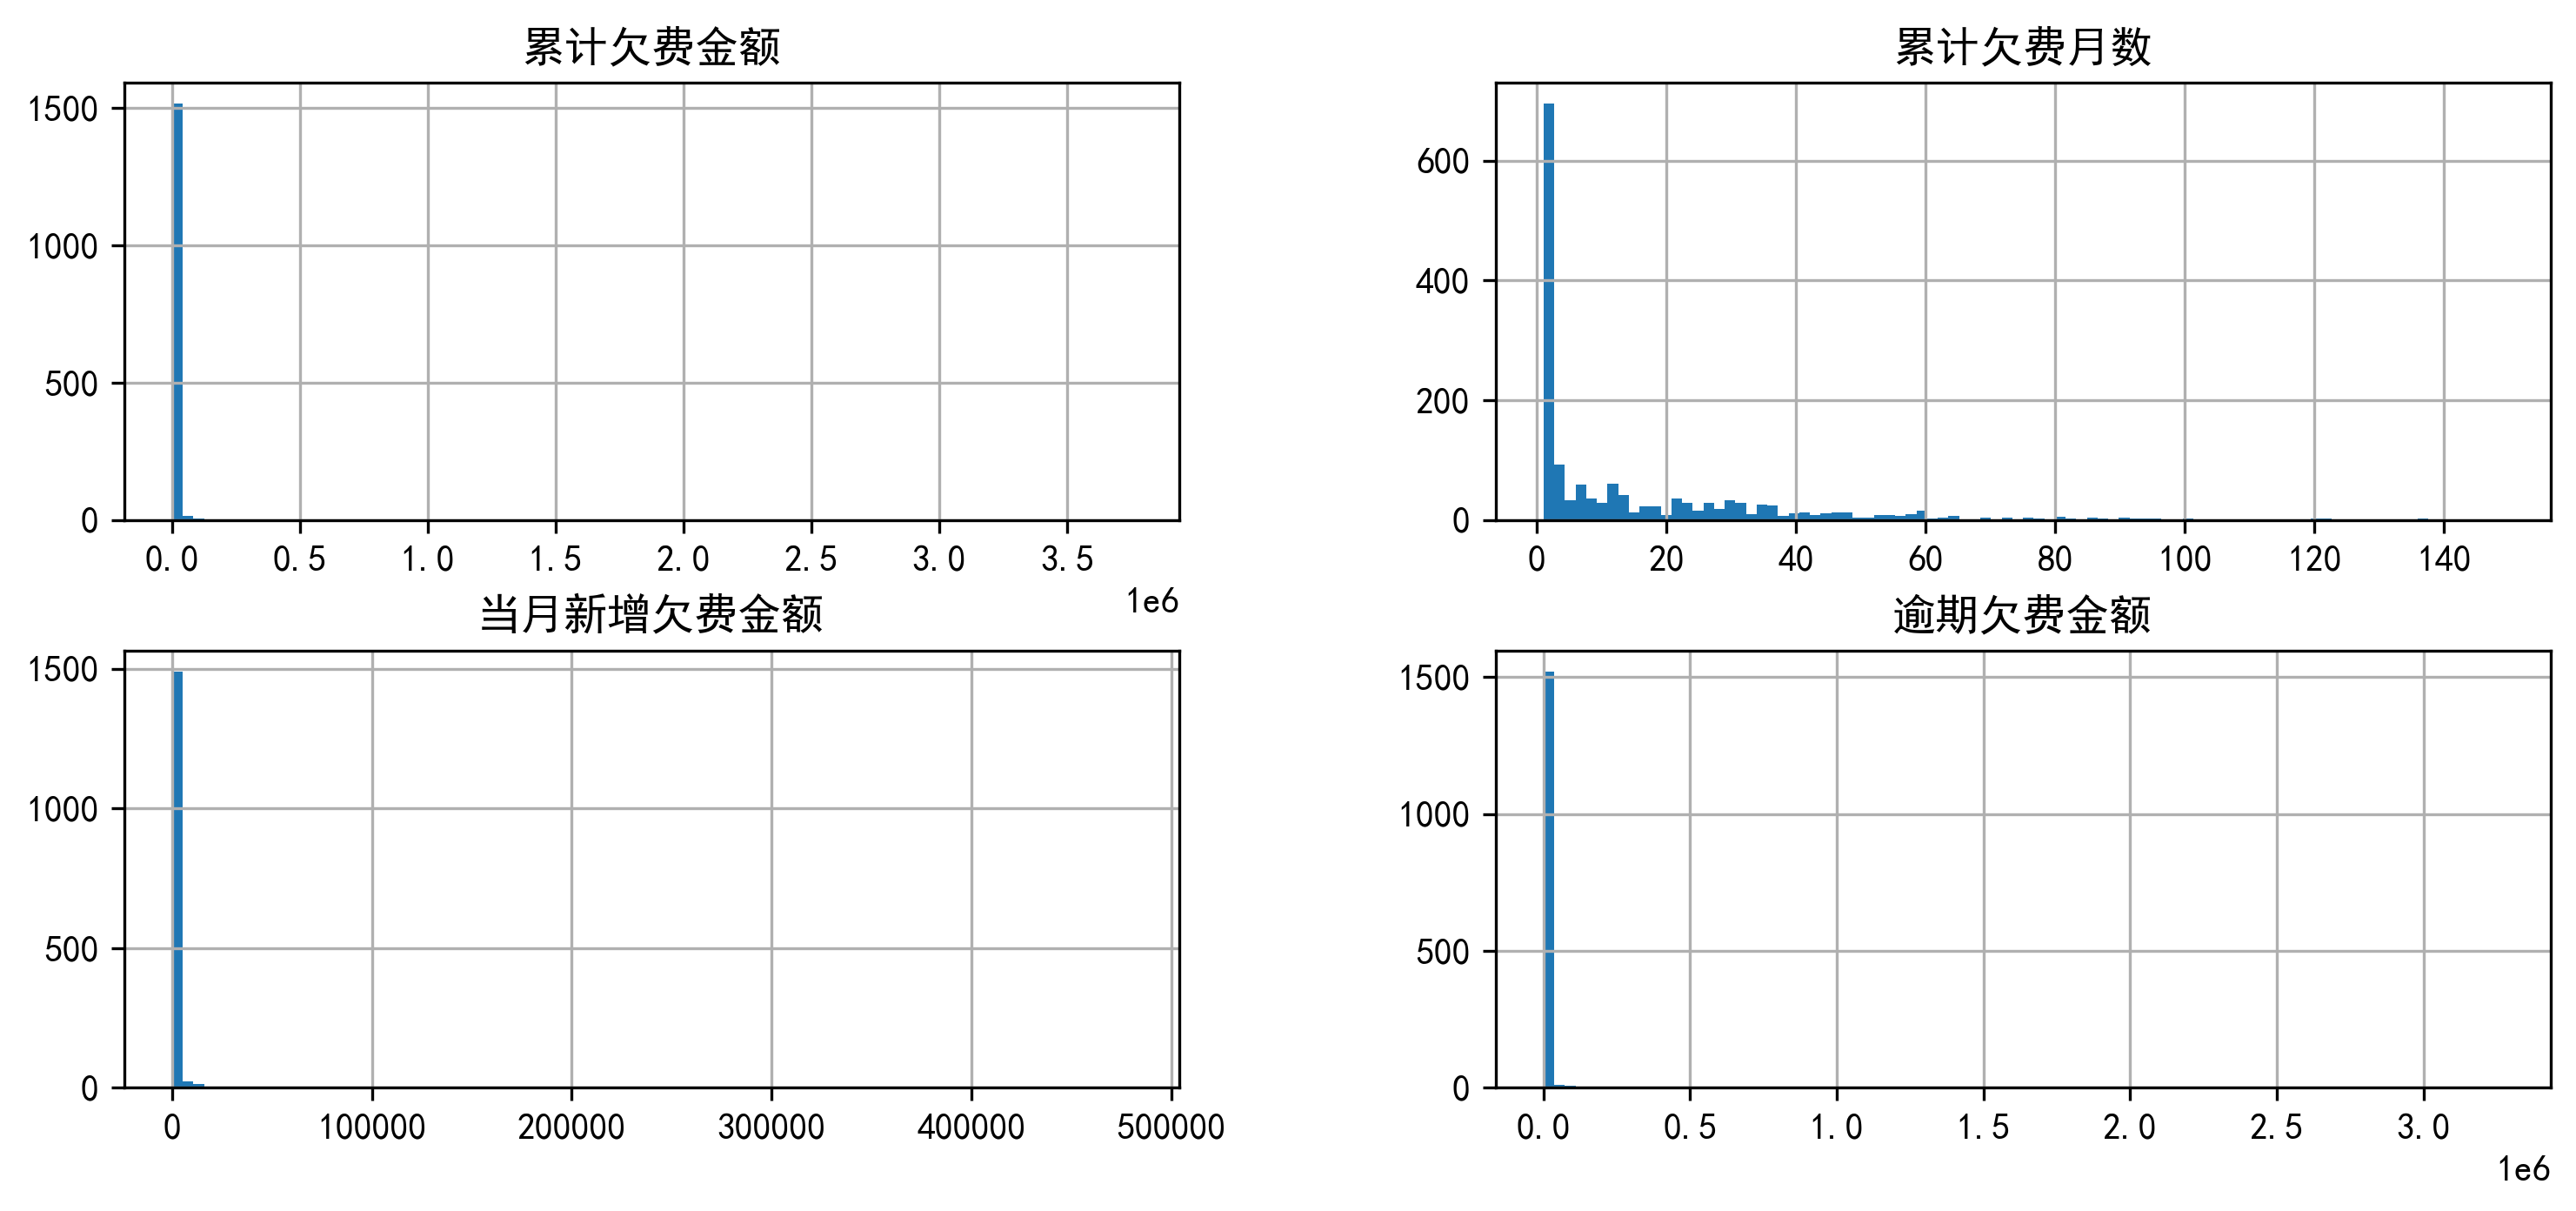

In [4]:
# 分月份的整体样本欠费分布
numetric_col = ['累计欠费金额', '累计欠费月数', '当月新增欠费金额', '逾期欠费金额']
df_owe.rename(columns={'owe_year_fee':numetric_col[0], 
                       'owe_year_num':numetric_col[1], 
                       'owe_month_fee':numetric_col[2], 
                       'pay_out_arre':numetric_col[3]},inplace=True)

timeStamp = datetime.datetime.strptime(str(input('请输入关注年-月(YYYY-MM)：')), '%Y-%m')
df_owe[df_owe['month_id'] == timeStamp][numetric_col].hist(bins=90, figsize=(12,5))

##### 坏账客户计数统计

In [5]:
unique_cus = df_owe.groupby('month_id')['natural_cust_id'].agg('nunique')
df_cus_total = pd.DataFrame(data=unique_cus, columns=['自然客户数'],index=unique_cus.index)
# df_cus_total['month_id'] = df_cus_total['month_id'].map(lambda x:datetime.datetime.strptime(str(x),'%Y-%m'))
# df_cus_total.set_index('month_id',inplace=True)

df_cus_total = df_owe.groupby('month_id')['natural_cust_id'].agg('nunique')
df_cus_owe_all = df_owe[df_owe['累计欠费金额'] > 0].groupby('month_id')['natural_cust_id'].nunique() # 累计欠费客户数

df_cus_new_owe = df_owe[df_owe['当月新增欠费金额'] > 0].groupby('month_id')['natural_cust_id'].nunique() # 新增欠费客户数

df_cus_overdue_all = df_owe[df_owe['逾期欠费金额'] > 0].groupby('month_id')['natural_cust_id'].nunique() # 逾期欠费客户数

agg_df = pd.concat([df_cus_total, df_cus_owe_all, df_cus_new_owe, df_cus_overdue_all], axis=1)
agg_df.columns = ['自然客户数','累计欠费客户数', '当月新增欠费客户数', '逾期客户数']
agg_df['累计欠费客户数占比'] = np.round(agg_df['累计欠费客户数'] / agg_df['自然客户数'], 4)
agg_df['当月新增欠费客户数占比'] = np.round(agg_df['当月新增欠费客户数'] / agg_df['自然客户数'], 4)
agg_df['逾期客户数占比'] = np.round(agg_df['逾期客户数'] / agg_df['自然客户数'], 4)

print('>>> 总自然客户数：',df_owe['natural_cust_id'].nunique())
agg_df

>>> 总自然客户数： 2408


,自然客户数,累计欠费客户数,当月新增欠费客户数,逾期客户数,累计欠费客户数占比,当月新增欠费客户数占比,逾期客户数占比
month_id,,,,,,,
2021-02-01,1338,1338,1014,804,1.0000,0.7578,0.6009
2021-03-01,1368,1367,1023,788,0.9993,0.7478,0.5760
2021-04-01,1395,1394,1028,815,0.9993,0.7369,0.5842
2021-05-01,1419,1418,1042,809,0.9993,0.7343,0.5701
2021-06-01,1437,1436,1054,853,0.9993,0.7335,0.5936
2021-07-01,1327,1325,979,770,0.9985,0.7378,0.5803
2021-08-01,1454,1452,1032,872,0.9986,0.7098,0.5997
2021-09-01,808,808,584,488,1.0000,0.7228,0.6040
2021-10-01,1467,1466,1030,891,0.9993,0.7021,0.6074


<Axes: xlabel='月账期', ylabel='独立自然客户数'>

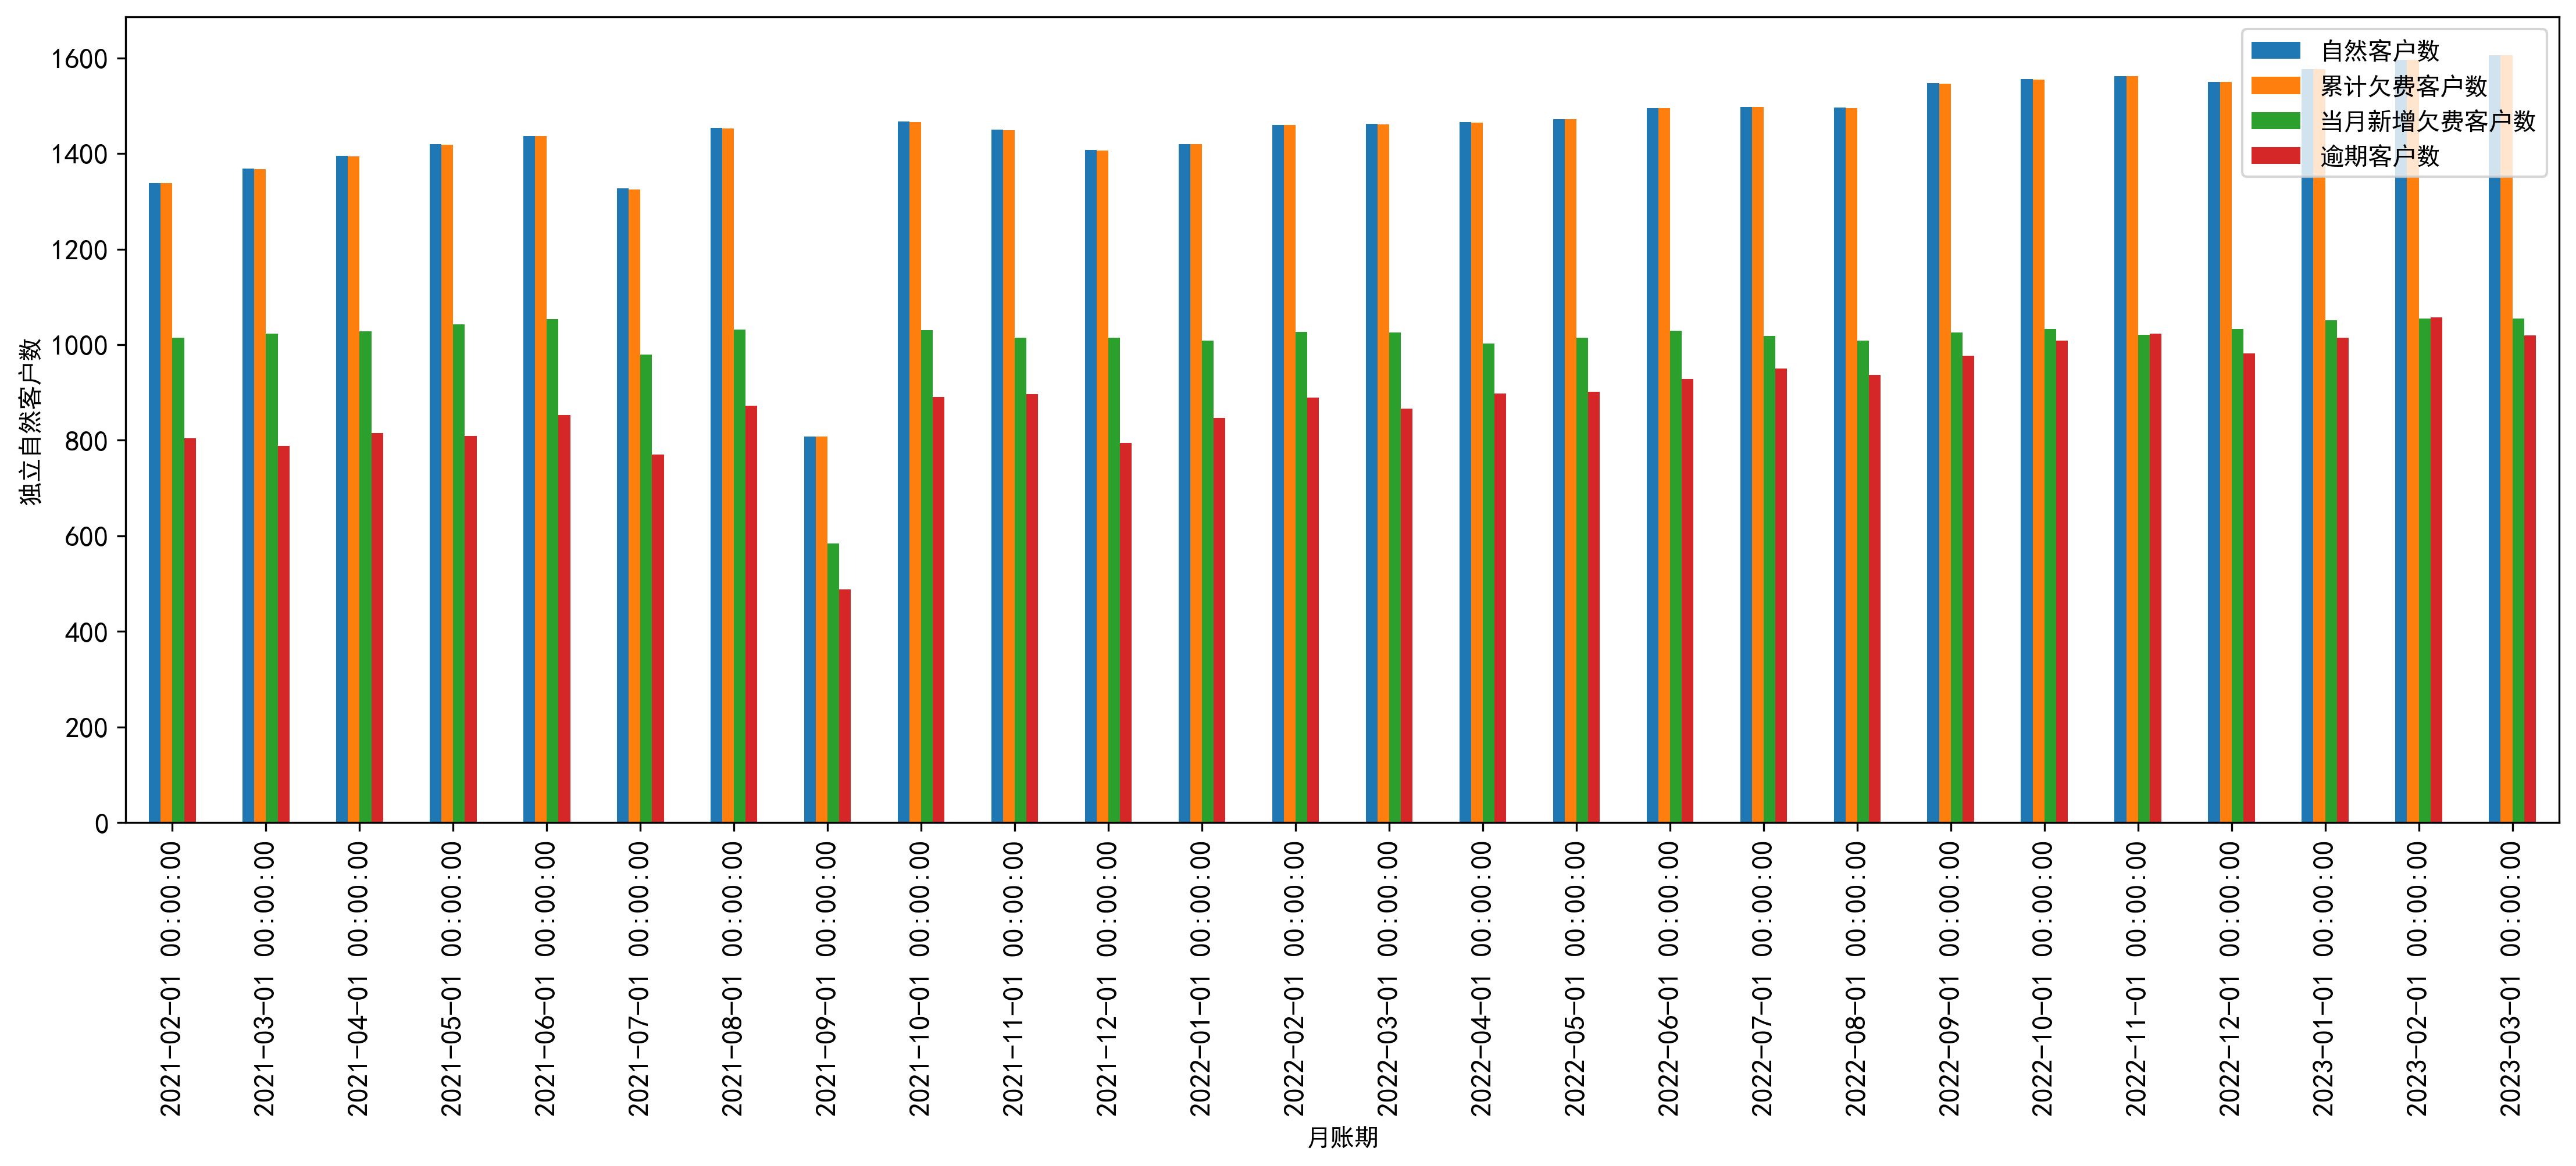

In [6]:
agg_df[['自然客户数', '累计欠费客户数', '当月新增欠费客户数', '逾期客户数']].plot(kind='bar',
                                                                             figsize=(18,6), xlabel='月账期', ylabel='独立自然客户数', 
                                                                             fontsize=12, rot=90)

<Axes: xlabel='月账期', ylabel='占累计自然客户数的百分比'>

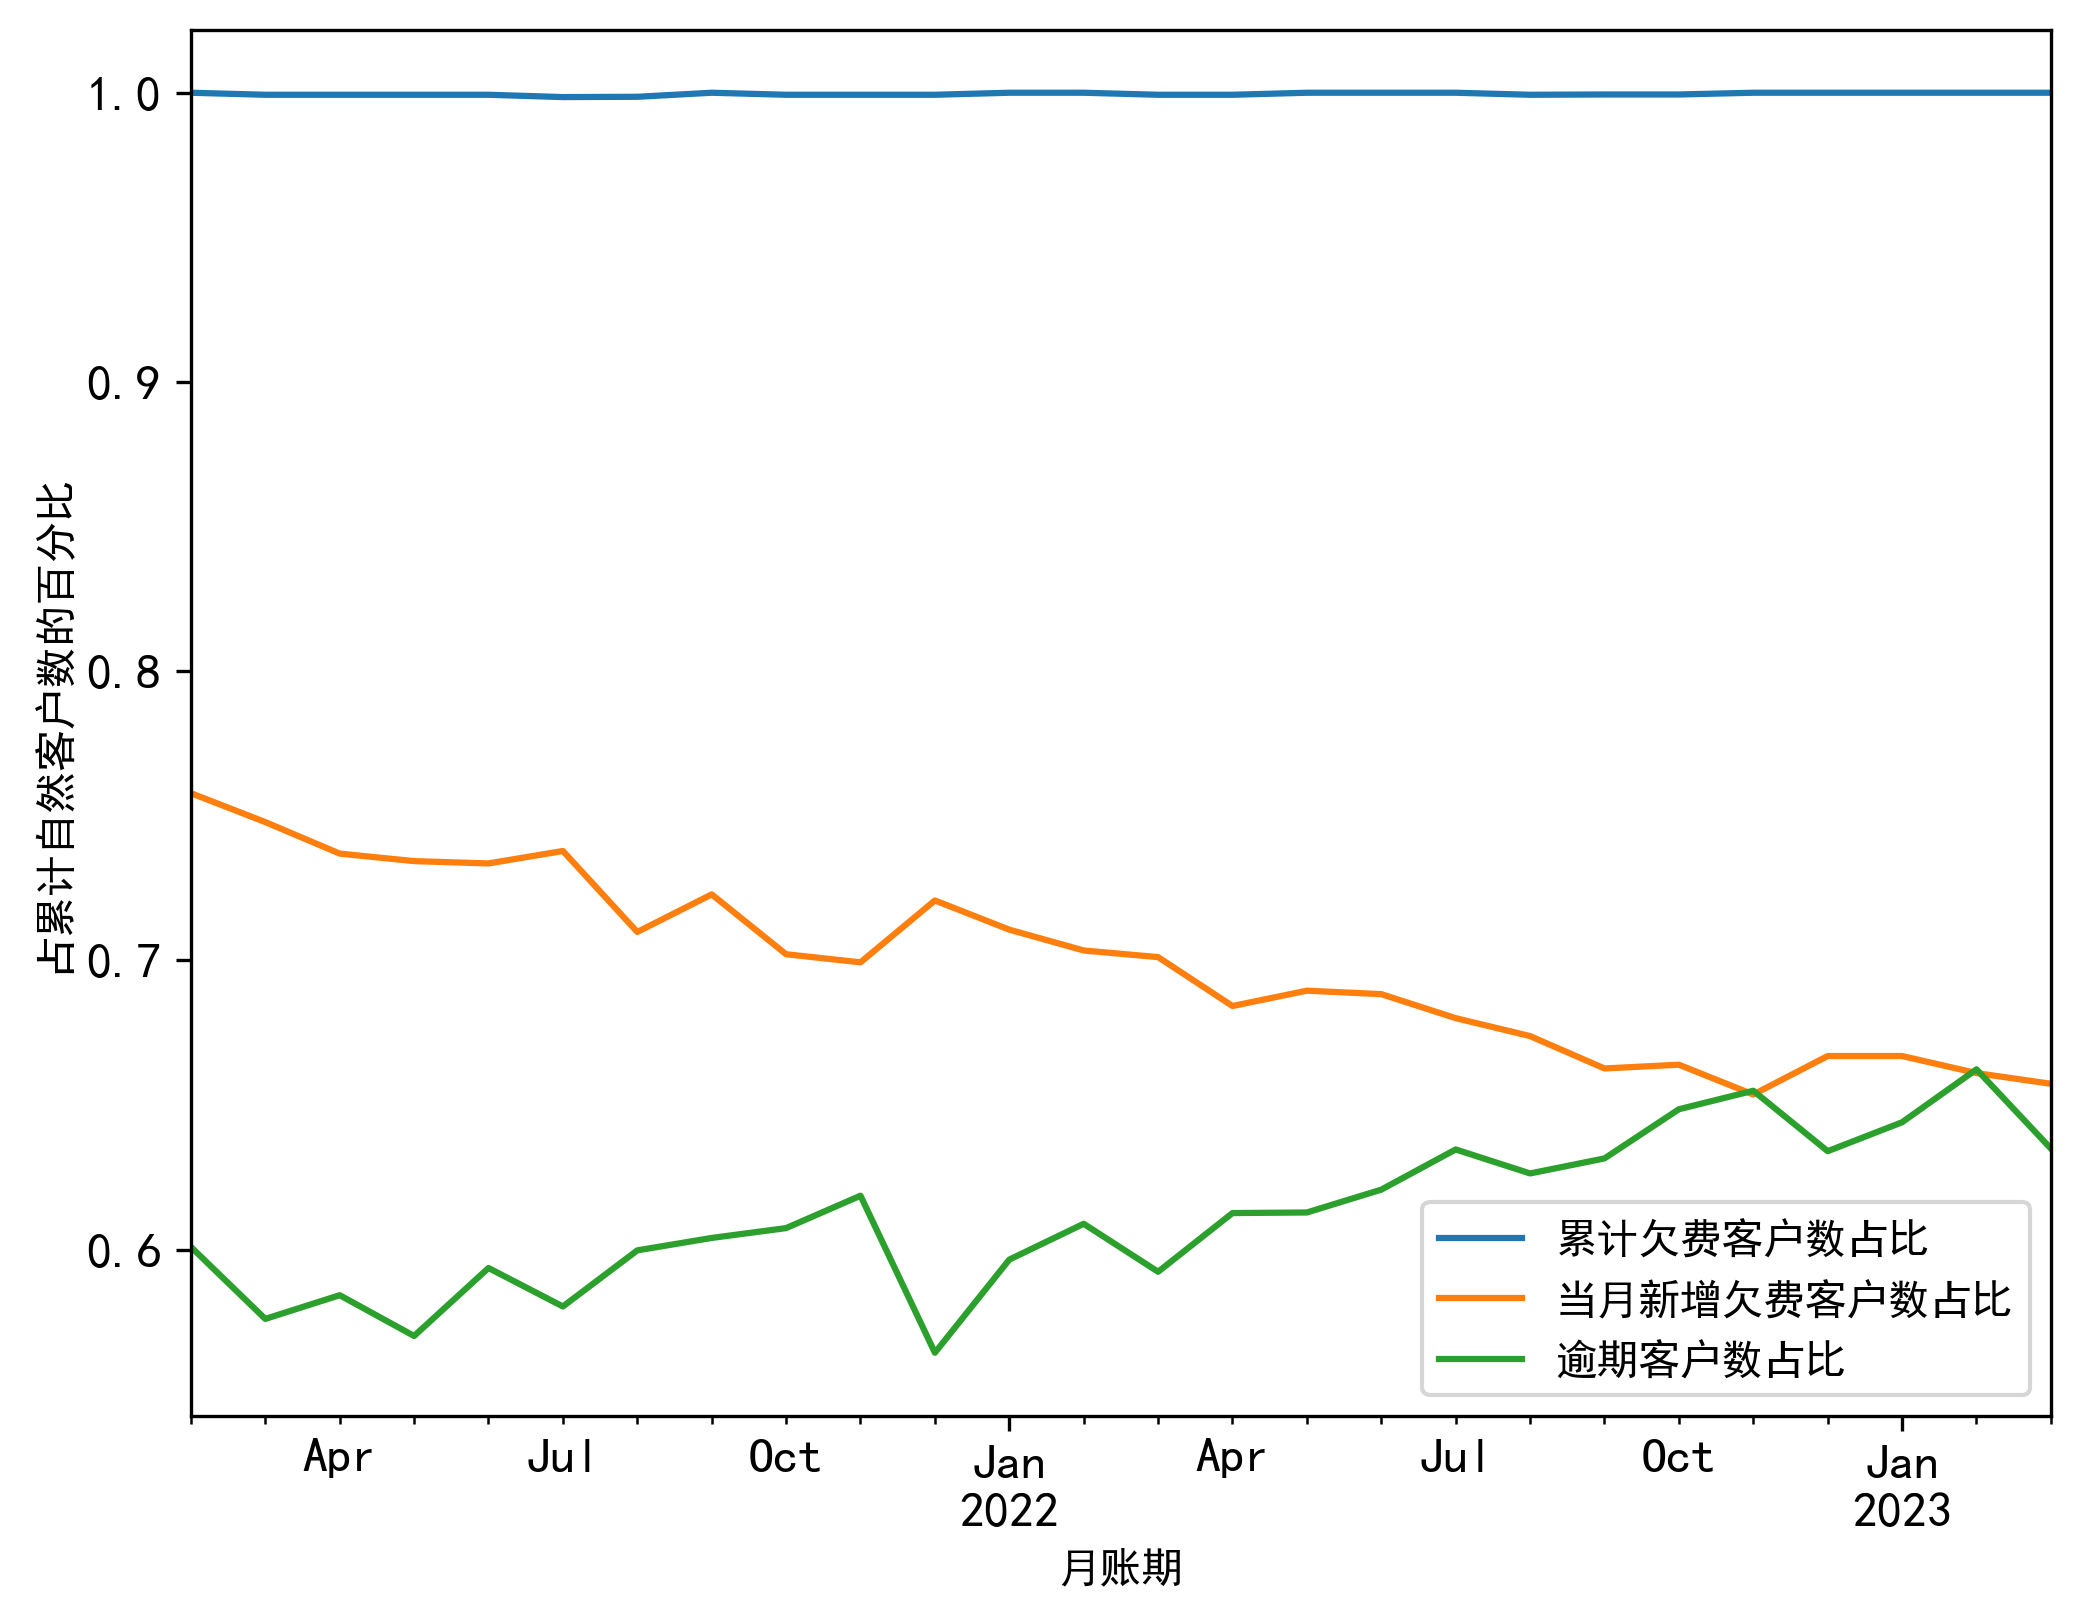

In [8]:
agg_df[['累计欠费客户数占比', '当月新增欠费客户数占比', '逾期客户数占比']].plot(kind='line', 
                                                                           figsize=(8,6), xlabel='月账期', ylabel='占累计自然客户数的百分比',
                                                                           fontsize=12, rot=0)

##### 坏账金额统计

In [9]:
# 先按照natural_cust_id和month_id两列进行去重
df_owe_cleaned = df_owe.drop_duplicates(subset=['natural_cust_id', 'month_id'], keep='first')
df_owe_cleaned

,natural_cust_id,累计欠费金额,累计欠费月数,当月新增欠费金额,owe_year_basis,owe_month_ratio,逾期欠费金额,pay_out_ratio,pay_out_basis,month_id
0,33864123,33.00,57,0.00,0,0,33.00,0,0,2023-02-01
1,33791123,11100.00,28,400.00,76.19,3.74,10700.00,3.88,81.36,2023-02-01
2,34752123,1.13,1,1.13,494.74,1155.56,0.00,-,-,2023-02-01
3,88914123,336.09,37,172.00,159.05,104.82,164.09,26.48,26.48,2023-02-01
4,88985123,20947.65,1,20947.65,29.2,1.23,0.00,-,-,2023-02-01
...,...,...,...,...,...,...,...,...,...,...
37624,36453123,1000.00,1,1000.00,0,0,0.00,-,-,2022-03-01
37625,39229123,1.04,3,0.76,-99.38,271.43,0.28,75,-,2022-03-01
37626,34764123,1987.78,1,1987.78,-,0.98,0.00,-,-,2021-04-01
37627,36188123,11.79,3,3.00,-,34.13,8.79,0,-,2021-11-01


In [10]:
agg_amt_df = df_owe_cleaned.groupby('month_id')[['累计欠费金额','当月新增欠费金额','逾期欠费金额']].agg(['mean','median','max','std'])
agg_amt_df

累计欠费金额                                         当月新增欠费金额  \
                    mean   median         max            std         mean   
month_id                                                                    
2021-02-01   7255.342885  198.855  1547840.92   72187.435129  2002.648371   
2021-03-01   8955.906791  197.505  2493157.20   95436.192658  2295.042485   
2021-04-01   9606.803054  195.010  2630996.18  100252.992108  2163.630487   
2021-05-01  10000.074531  186.200  2722195.56  104302.201934  2047.556681   
2021-06-01   9903.094593  197.780  2828297.80  106392.348768  2395.753786   
2021-07-01  11684.673662  194.180  2874929.86  120908.612770  2404.367573   
2021-08-01  10736.618769  179.730  2970053.31  122654.999726  2144.588556   
2021-09-01   8063.125458  169.965  1811374.56   82677.974131  2052.503589   
2021-10-01   9954.430164  178.200  3170416.59  112536.934680  2596.753531   
2021-11-01  11135.406683  188.025  3488504.47  131601.838440  3003.533531   
2021-12-01  10075.324229  180.000  3563289.97  128745.485514  1981.877768   
2022-01-01  10617.891761  196.035  3608013.83  132573.685502  1906.976085   
2022-02-01  11730.430993  181.120  3696792.05  141232.249336  2386.972158   
2022-03-01  14340.101484  182.500  3787269.33  156882.569918  3141.885479   
2022-04-01  14396.557626  199.000  3781773.37  158333.548937  2667.253076   
2022-05-01  13599.967385  185.655  3114416.82  149535.269894  1888.997901   
2022-06-01  18210.856475  186.810  3377262.31  190928.636991  7841.343719   
2022-07-01  14711.414395  199.700  3539918.28  166416.588852  1965.827902   
2022-08-01  15016.064606  208.140  3668082.15  162795.444910  2766.923556   
2022-09-01  14702.207382  200.000  4181173.84  166094.497465  2139.177292   
2022-10-01  14640.315900  197.560  4609943.23  168687.669975  1899.882076   
2022-11-01  14788.426895  194.200  5058641.01  183267.060447  1984.580262   
2022-12-01  12110.935391  174.500  3749533.44  154081.062655  1847.799413   
2023-01-01  13029.177246  186.585  4230810.40  163272.571767  2404.975063   
2023-02-01  13530.692694  184.060  4712670.91  166537.912305  2134.403885   
2023-03-01  10203.602166  180.560  5194531.42  160881.295493  2531.830222   

                                                     逾期欠费金额          \
            median         max            std          mean  median   
month_id                                                              
2021-02-01  66.805   337815.55   14139.538334   5308.100845  13.520   
2021-03-01  60.050   356462.60   17821.503243   6961.102193  12.880   
2021-04-01  52.000   387362.19   16350.232262   7454.188681  14.260   
2021-05-01  51.020   326928.52   15208.323366   8131.592629  10.390   
2021-06-01  53.750   475016.60   19658.904224   7893.252338  14.850   
2021-07-01  53.620   276309.22   17167.569871   9604.289118  11.320   
2021-08-01  48.000   343056.66   16636.822191   8851.153611  16.390   
2021-09-01  57.680   377697.48   17726.801668   6665.305520  22.800   
2021-10-01  41.000   520938.64   21060.396964   8021.375937  18.800   
2021-11-01  44.000  1011921.70   31719.326114   8474.725966  21.905   
2021-12-01  49.000   313844.96   15124.099301   8347.276581   9.640   
2022-01-01  48.985   257416.53   12971.441236   8869.423923  14.790   
2022-02-01  41.630   960880.00   28100.518662  10108.341425  19.070   
2022-03-01  42.500   800740.00   28136.902097  12155.064870  14.420   
2022-04-01  38.960   442143.98   21634.478486  12457.000641  19.415   
2022-05-01  38.500   266976.98   13821.189073  11878.079966  19.330   
2022-06-01  40.480  3371421.19  125071.646842  13353.375980  22.880   
2022-07-01  40.650   412460.31   15907.347747  13013.842305  29.720   
2022-08-01  38.780  1022642.91   30440.101526  12650.195201  28.005   
2022-09-01  33.810   513091.69   18452.780092  12587.130039  29.450   
2022-10-01  35.000   456776.47   17981.080348  12754.019550  30.570   
2022-11-01  30.355   473271.65   16979.104425  12867.589462  33.905   
2022-12-0

<Axes: xlabel='月账期', ylabel='平均金额（元）'>

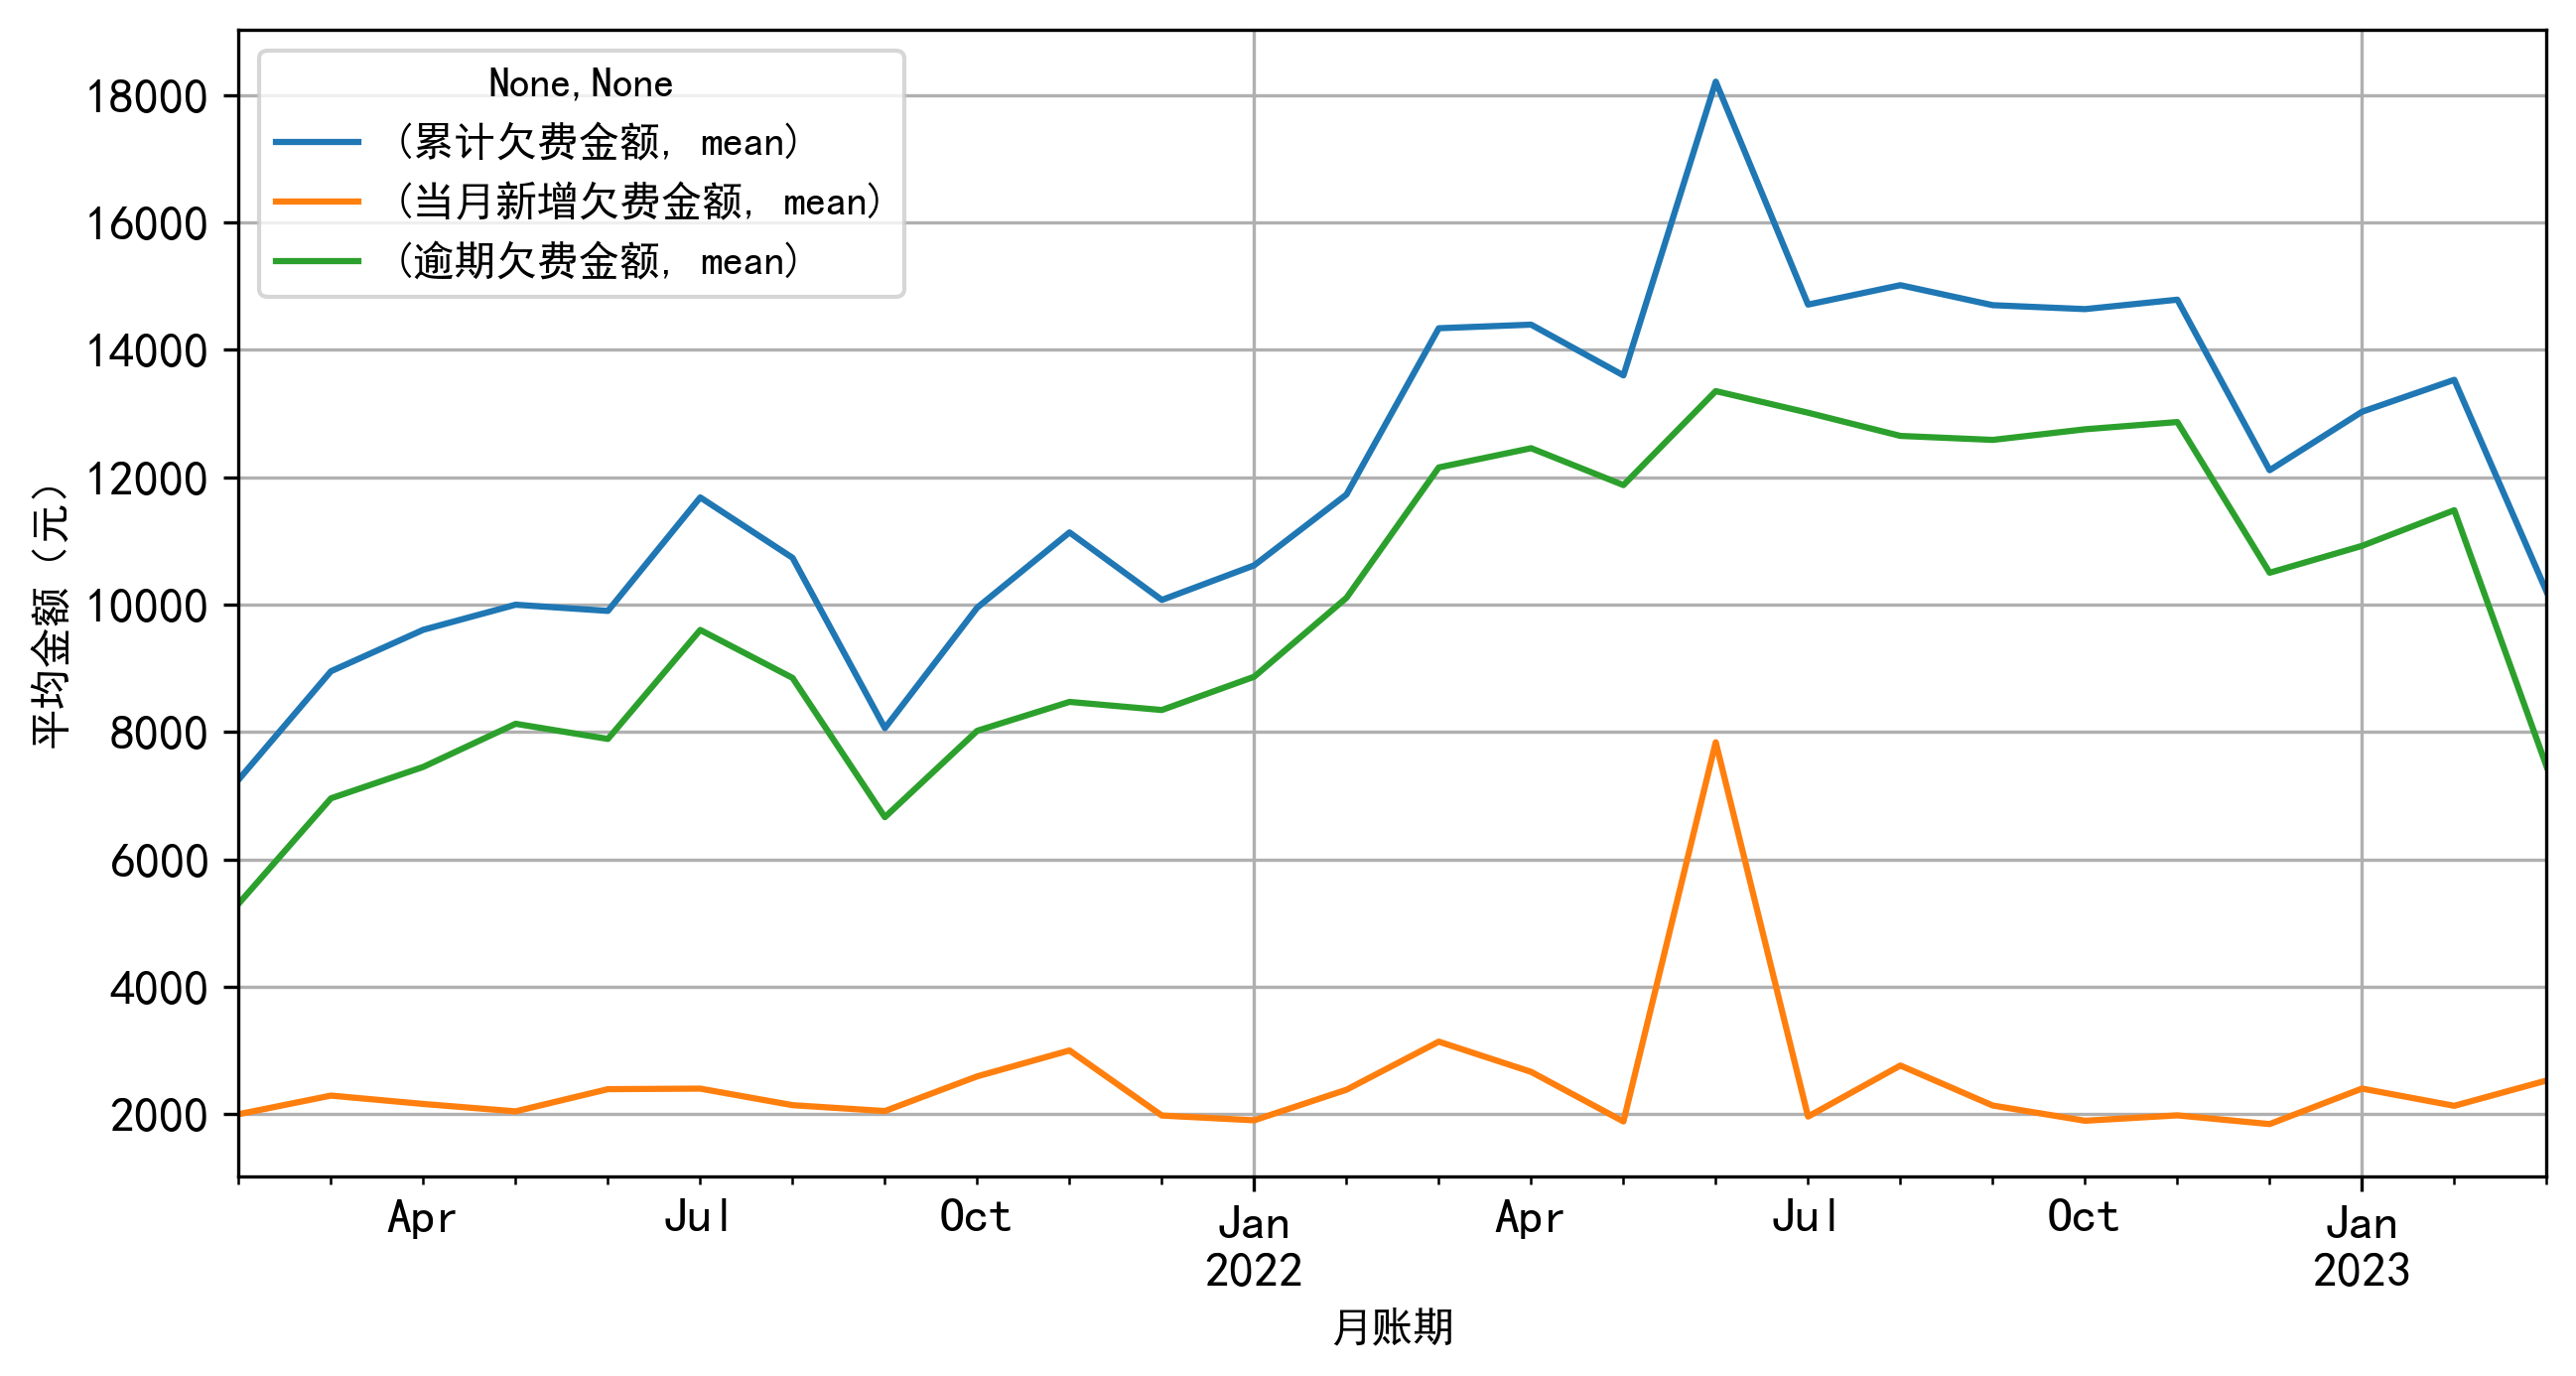

In [11]:
agg_amt_mean = df_owe_cleaned.groupby('month_id')[['累计欠费金额','当月新增欠费金额','逾期欠费金额']].agg(['mean'])
agg_amt_mean.plot(kind='line',
                  figsize=(10,5), xlabel='月账期', ylabel='平均金额（元）', grid=True, 
                  fontsize=12, rot=0)

<Axes: xlabel='月账期', ylabel='中位金额（元）'>

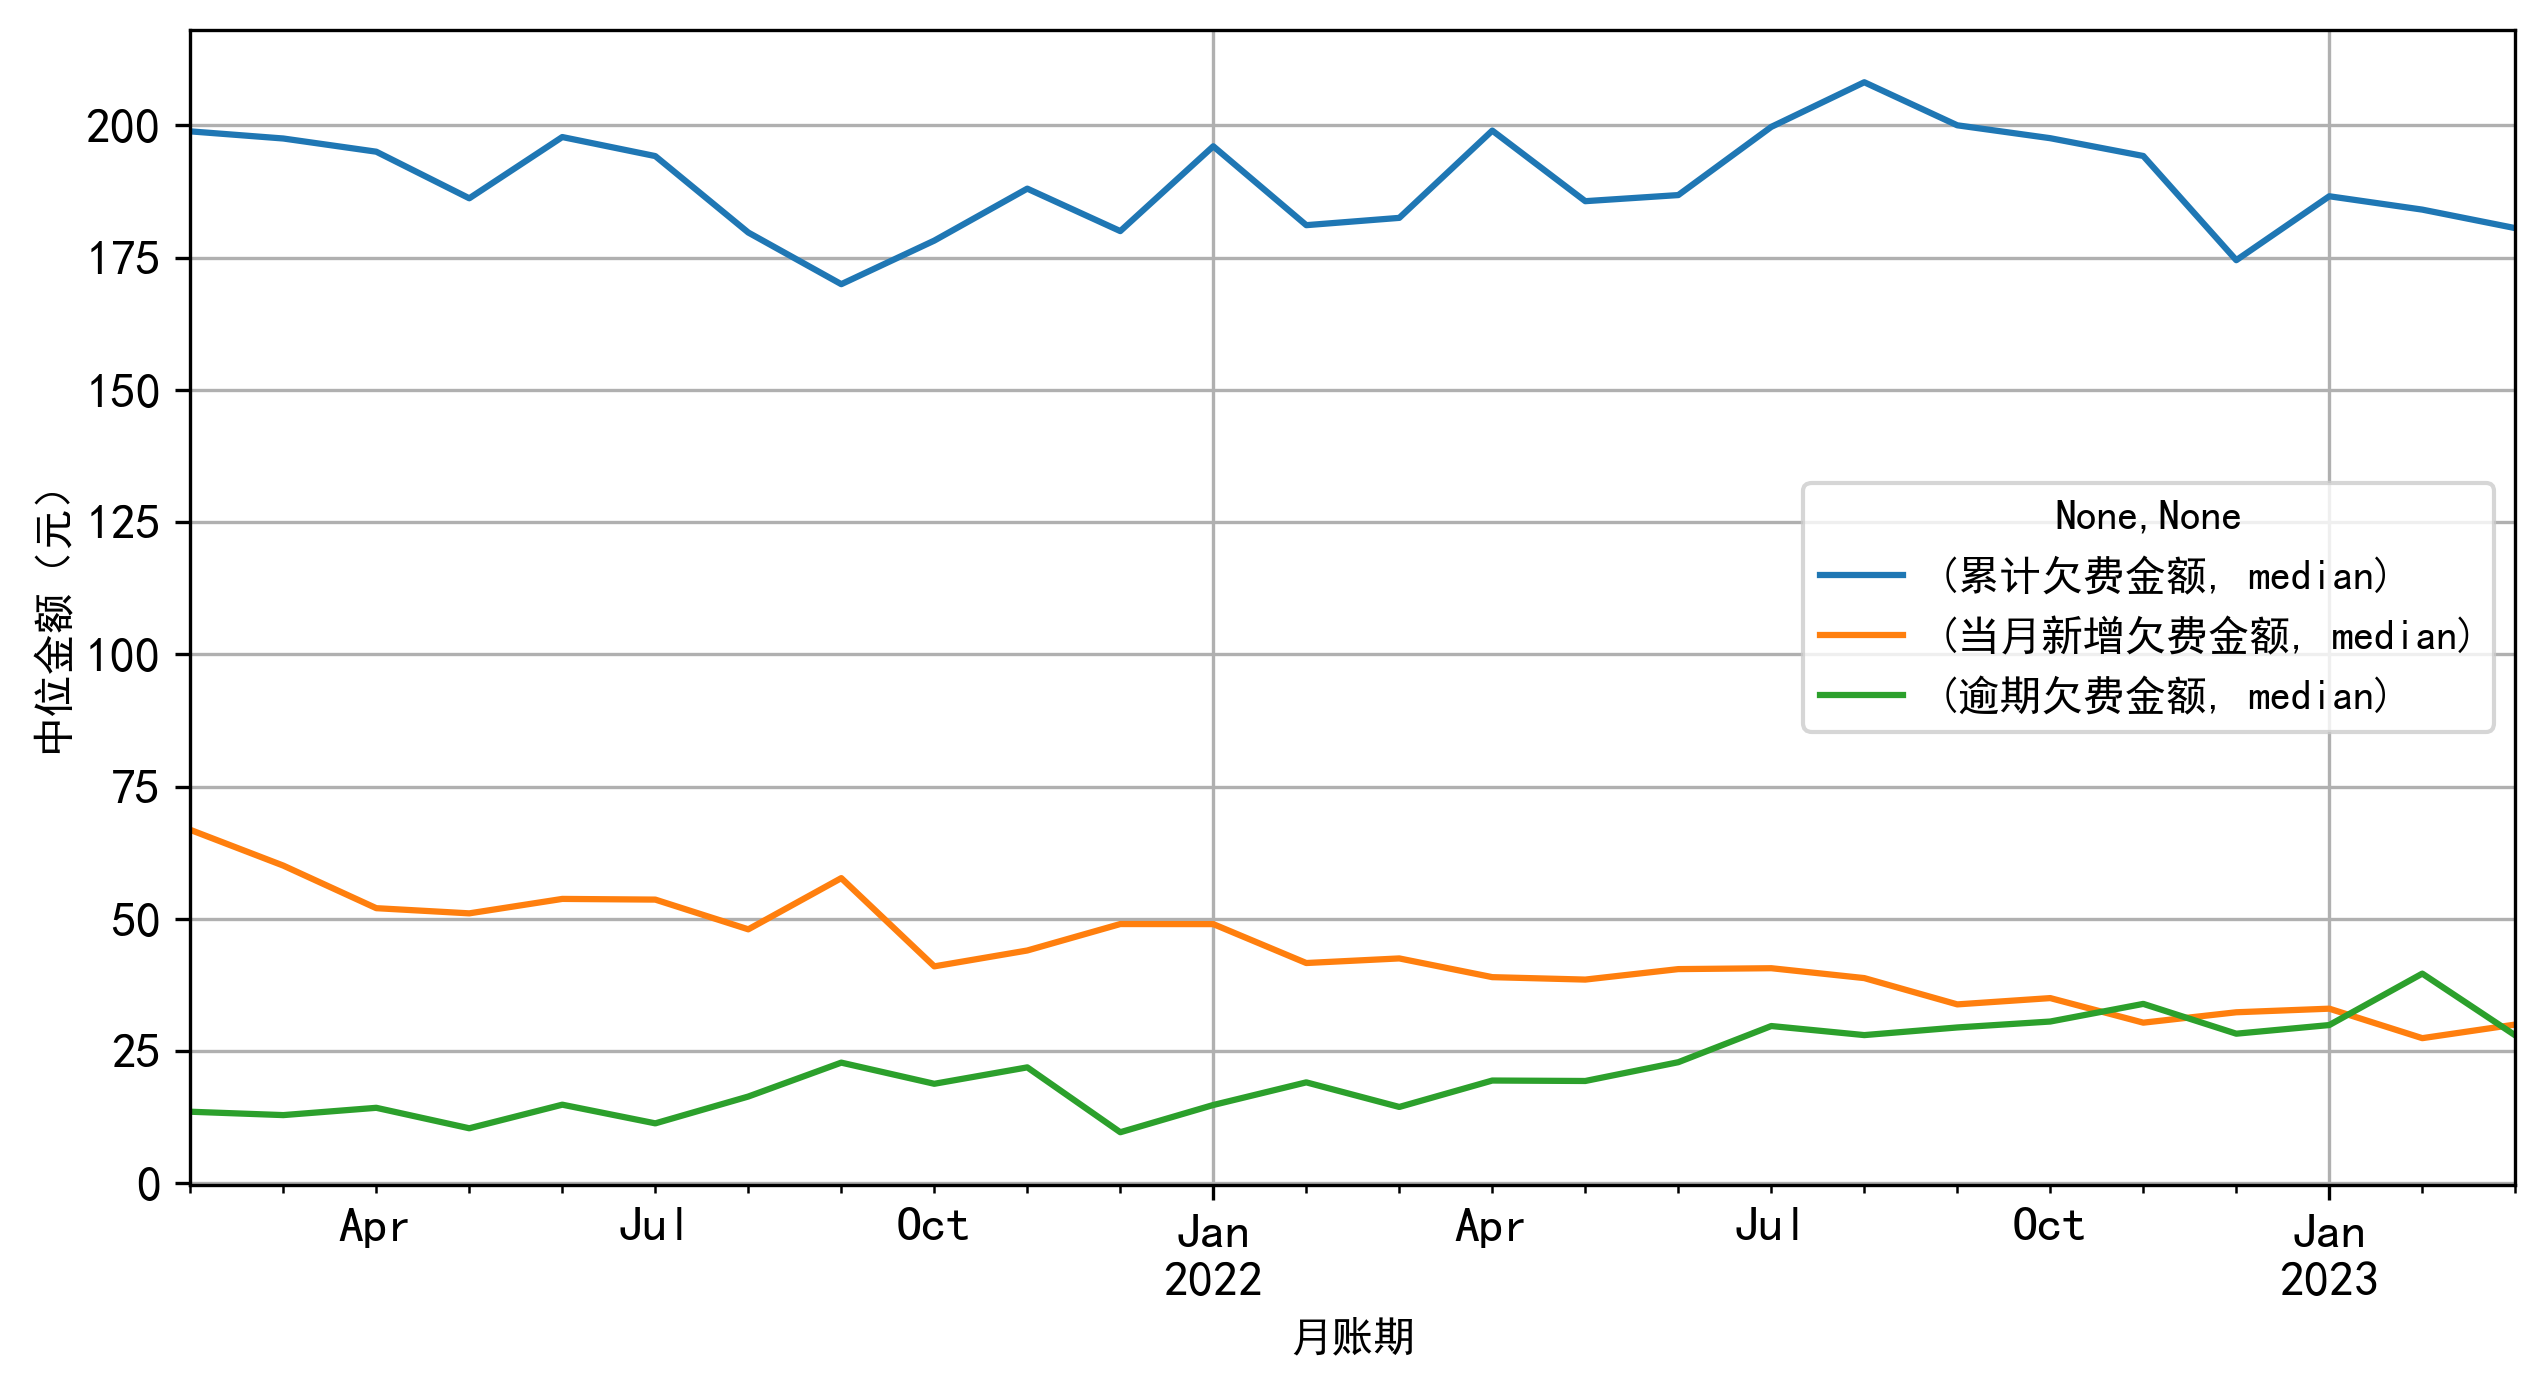

In [48]:
agg_amt_median = df_owe_cleaned.groupby('month_id')[['累计欠费金额','当月新增欠费金额','逾期欠费金额']].agg(['median'])
agg_amt_median.plot(kind='line',
                  figsize=(10,5), xlabel='月账期', ylabel='中位金额（元）', grid=True, 
                  fontsize=12, rot=0)

<Axes: xlabel='月账期', ylabel='最大金额（元）'>

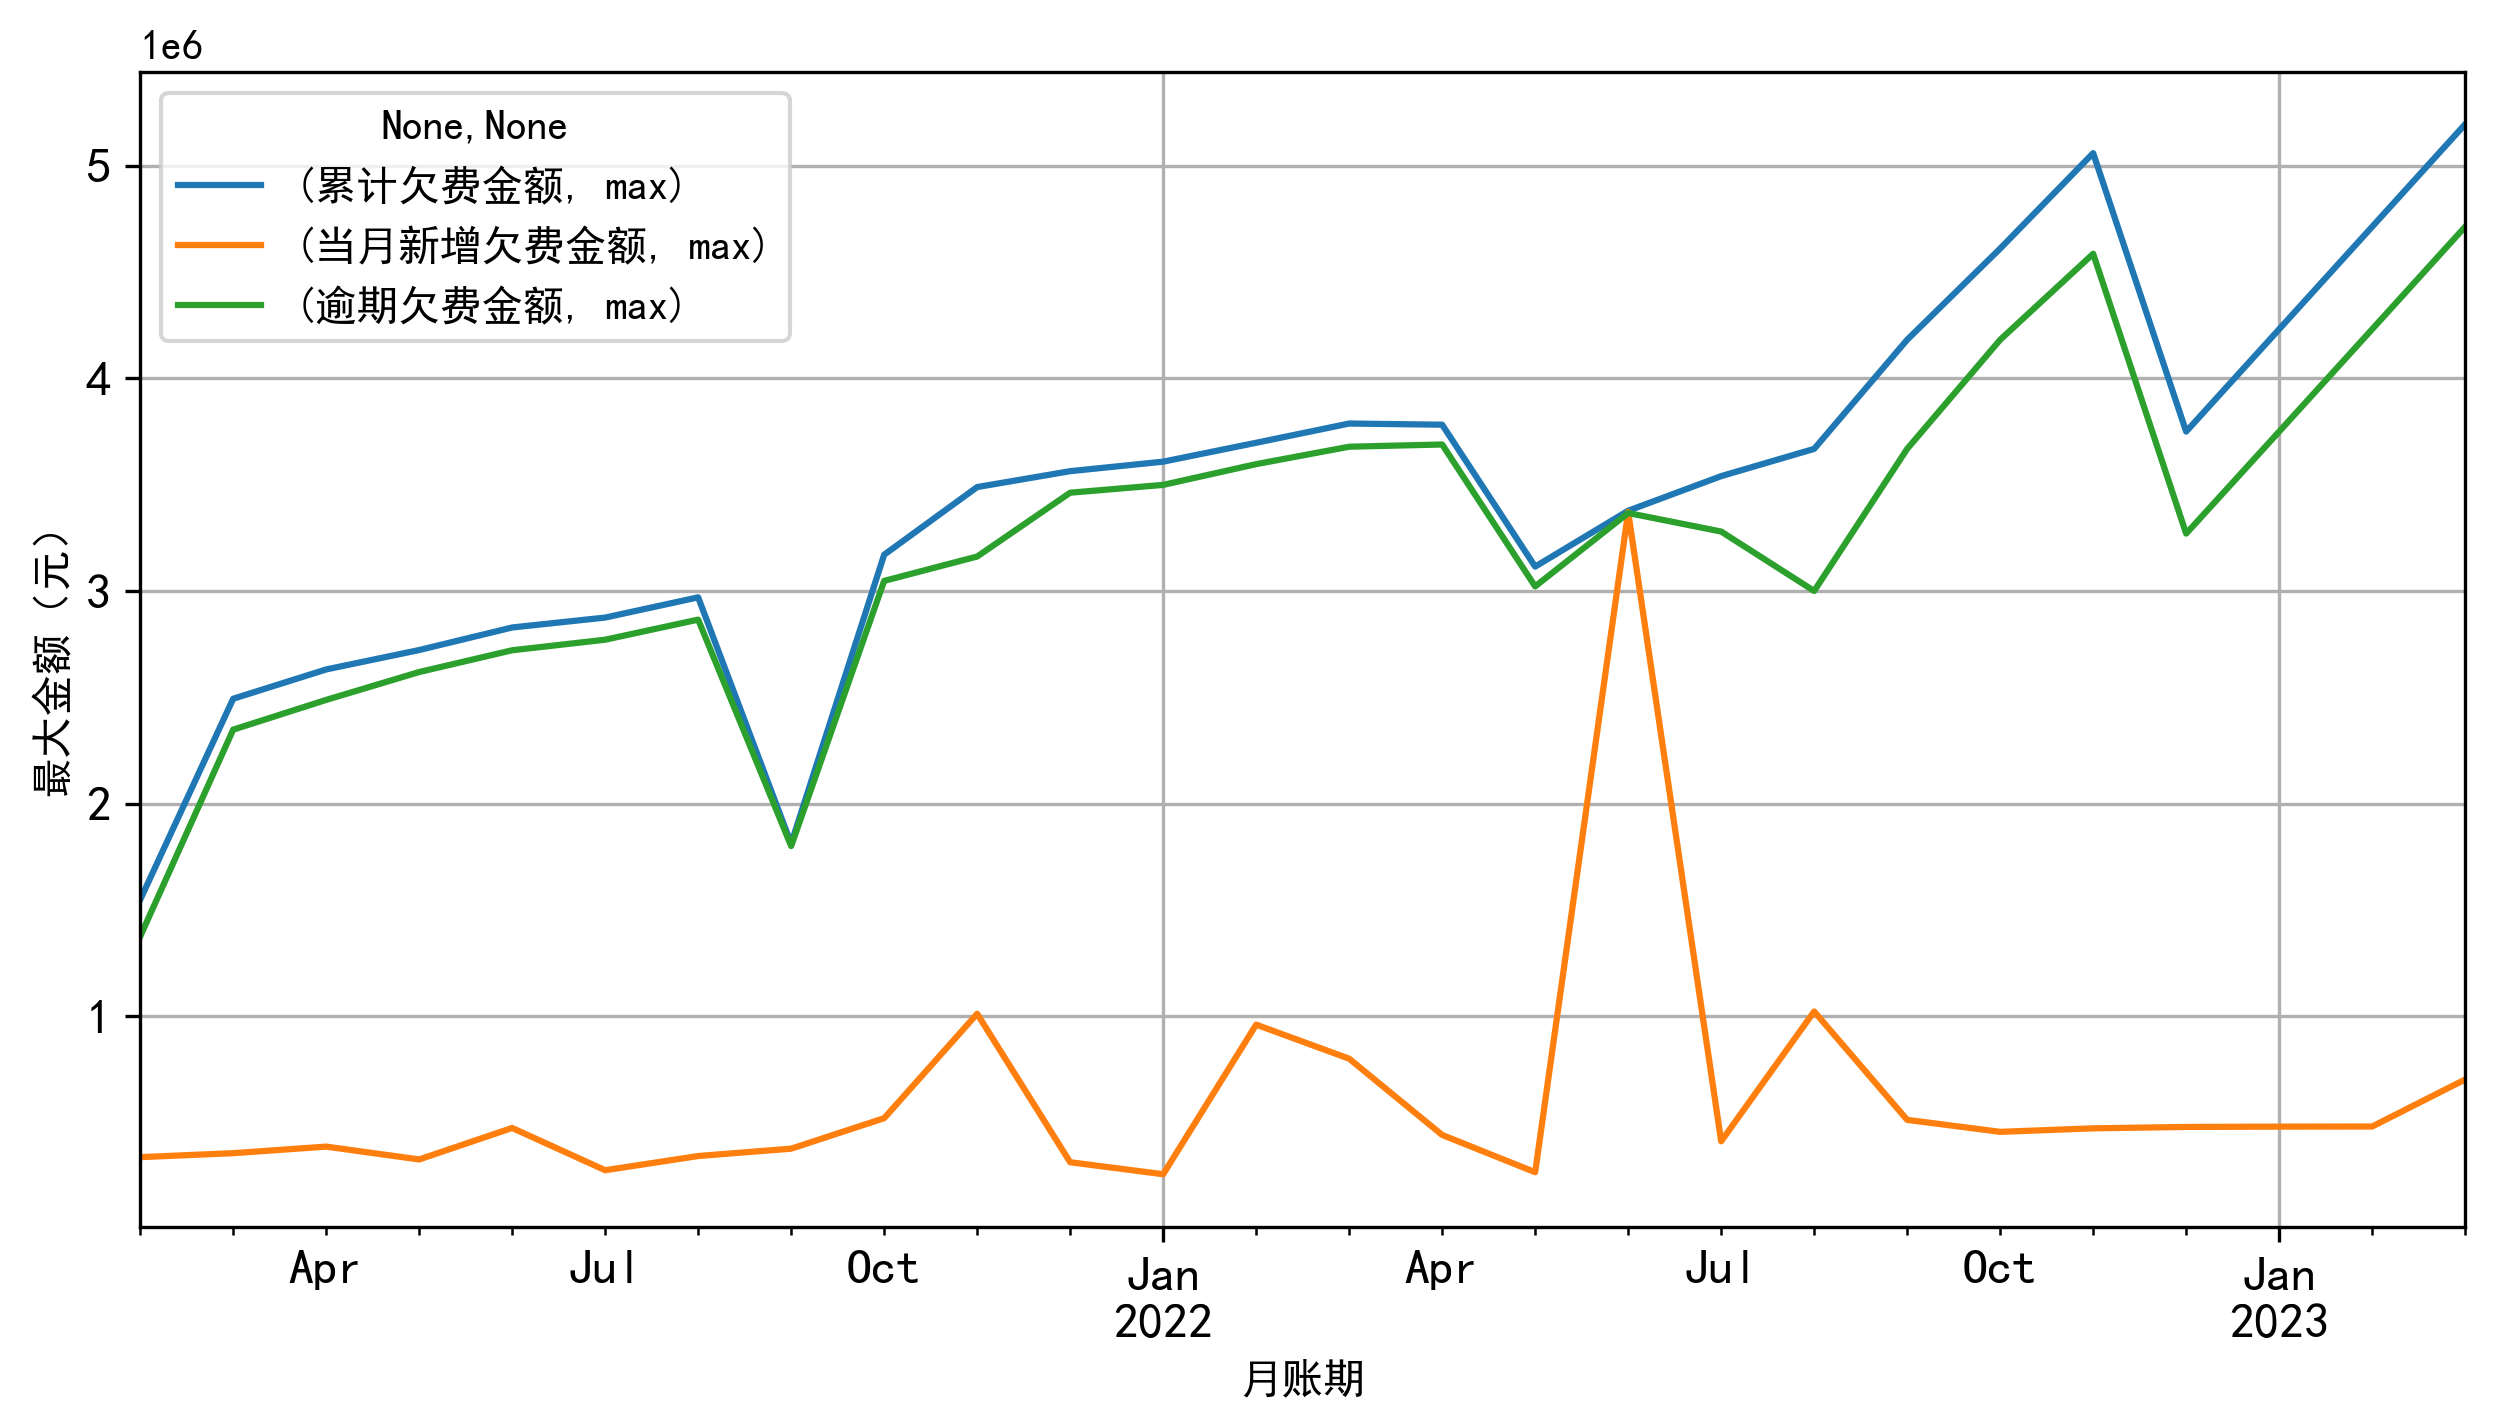

In [49]:
agg_amt_max = df_owe_cleaned.groupby('month_id')[['累计欠费金额','当月新增欠费金额','逾期欠费金额']].agg(['max'])
agg_amt_max.plot(kind='line',
                 figsize=(10,5), xlabel='月账期', ylabel='最大金额（元）', grid=True, 
                 fontsize=12, rot=0)

#### 特征目标宽表 (已聚合)

##### 目标分析

- **target_M2plus**：根据表现期（202301-03账期）逾期状态是否出现M2+（连续两个月及以上），分为好（=0）与坏（=1）；
    - 业务含义：**probability**。客户在观察期内逾期增速、逾期动机、以及恶化趋势; 越大，说明某客户越容易变坏
    - 指标本质：取决于本账期逾期状态相对于上一账期状态的动态差距，是时间敏感的。

- **target_owe_fee_rate**：表现期（202201-12账期）逾期金额占出账金额（年化）的比例，出账金额（年化）是非零月度出账金额的平均值乘以12
    - 业务含义：**serverity**。在控制掉客户自身逾期欠费金额的系统误差（年化出账金额作分母）后，再衡量客户逾期金额的大小；占比越高，说明某客户的无偏逾期程度越严重
    - 指标本质：取决于整个观察期内新增逾期金额总量与出账金额总量之间的相对幅度，是相对静态的。
    - **与M2+的可能关联：**
        - 1. ***状态决定趋势假说***：这里的target_owe_fee_rate在时间上先于target_M2plus，假设：超过X%的oew_fee_rate之后，更容易产生M2+（分箱求召回率 & 逻辑回归）；
        - 2. ***趋势反推状态假说***：假设：在存在M2+趋势的情况下，客户的无偏逾期金额会更高（独立样本T检验）

- **“逾期状态”/“逾期等级” 定义：**
    - 当月无逾期欠费，等级为0；
    - 当月逾期欠费金额（相对于上月？环比？）增加，等级为+1；
    - 当月逾期欠费金额（相比于上月？环比？）下降超30%，等级-1；
    - 当月逾期欠费金额不变或下降不足30%，等级不变

- (从宽) M2+逾期打标规则：观察点近6个月内，出现任一账期的 “逾期等级” >=2 ，则判定为逾期客户，否则不为逾期

- (从严) M1逾期打标规则：观察点近6个月内，出现任一账期的 “逾期等级” >=1 ，则判定为逾期客户，否则不为逾期

In [4]:
df_label = pd.read_excel('data/widetable_CR_202212_SQL_L10K.XLSX')
df_label.info()

c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25466 entries, 0 to 25465
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   NATURAL_CUST_ID                        25466 non-null  int64  
 1   target_M2plus                          25466 non-null  int64  
 2   target_owe_fee_rate                    25466 non-null  float64
 3   FLAG_M2_HISTORY                        25466 non-null  int64  
 4   OWETAG_OWE_FEE_N_RATIO_VL_OLD          25466 non-null  float64
 5   OWETAG_OWE_FEE_L12M_RATIO_VL_OLD       25466 non-null  float64
 6   OWETAG_OWE_TIME_L12M_MX_OLD            25466 non-null  int64  
 7   OWETAG_OWE_PERIOD_L12M_MX              25466 non-null  int64  
 8   COSHQW_ACCT_FEE_N_D3MR                 25466 non-null  float64
 9   COSHQW_CUST_N_D3M                      25466 non-null  int64  
 10  FLAG_M1_HISTORY                        25466 non-null  int64  
 11  CO

###### M2+分布

In [5]:
print('=='*10,'样本分布','=='*10,'\n')
print('>>> 逾期金额占比原始分布：',df_label['target_owe_fee_rate'].describe())
print('\n')
print('>>> M2+逾期样本（target_M2plus，表现期2023-01~2023-03，观察期2022-08~2023-03）分布:')
print(df_label['target_M2plus'].value_counts())
print('=='*10)
print(df_label['target_M2plus'].value_counts(normalize=True))

==================== 样本分布 ==================== 

>>> 逾期金额占比原始分布： count    2.546600e+04
mean     1.069213e+02
std      9.892050e+03
min     -8.421300e-02
25%      8.432500e-04
50%      2.667300e-02
75%      1.473490e-01
max      1.416667e+06
Name: target_owe_fee_rate, dtype: float64


>>> M2+逾期样本（target_M2plus，表现期2023-01~2023-03，观察期2022-08~2023-03）分布:
0    22609
1     2857
Name: target_M2plus, dtype: int64
0    0.887811
1    0.112189
Name: target_M2plus, dtype: float64


==================== 趋势反推状态假说 ==================== 

>>> Levene方差齐性检验结果： stat=0.01082159290720463, p-value=0.9171488320299397
>>> 方差齐性通过，采用等方差T检验
>>> 无法通过独立样本T检验： T-stat=0.10412243843638216; p-value=0.9170730043631167


<Axes: xlabel='target_M2plus', ylabel='target_owe_fee_rate'>

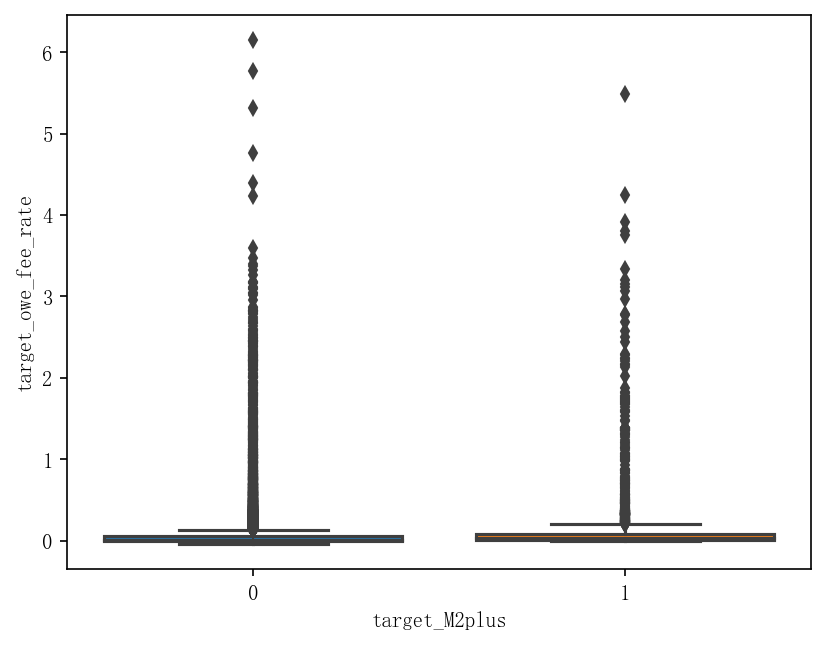

In [6]:
print('=='*10,'趋势反推状态假说','=='*10,'\n')
import math
from scipy.stats import bartlett, levene
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, ttest_rel

X1 = df_label[df_label['target_M2plus'] == 1]['target_owe_fee_rate']
X2 = df_label[df_label['target_M2plus'] == 0]['target_owe_fee_rate']

stat, p = levene(X1, X2, center='median')
print('>>> Levene方差齐性检验结果：',f'stat={stat}, p-value={p}')

if p > 0.05:
    print('>>> 方差齐性通过，采用等方差T检验')
    t, tp = ttest_ind(X1, X2, equal_var=True, random_state=667)
else:
    print('>>> 方差齐性未通过，采用Welch T检验')
    t, tp = ttest_ind(X1, X2, equal_var=False, random_state=667)
if tp < 0.05:
    print('>>> 通过独立样本T检验：',f'T-stat={t}; p-value={tp}')
else:
    print('>>> 无法通过独立样本T检验：',f'T-stat={t}; p-value={tp}')

sns.boxplot(x=df_label['target_M2plus'], 
            y=df_label['target_owe_fee_rate'].apply(lambda x:math.log10(x+1)), # 这里对原数据取对数方便可视化 
            saturation=0.9)

###### M2+与逾期占比的关系

In [7]:
print('=='*10,'状态决定趋势假说','=='*10,'\n')

def numetric_binary_recall(df, numetric_col, binary_col, start_q, end_q, groups):
    """Analysis Top n% Recall

    Args:
        df (_pd.DataFrame_): date set
        numetric_col (_str_): column name of numetric feature, usually X.
        binary_col (_str_): column name of binary feature, usually Y.
        start_q (_float_): start point of floor quantile.
        end_q (_float_): end point of floor quantile.
        groups (_int_): the number of quantile intervals.

    Returns:
        _pd.DataFrame_: dataframe describing relationship between quantile floor and recall.
    """
    q_name = [round(x,2) for x in np.linspace(start_q,end_q,groups,True)]
    q_index = df[numetric_col].quantile(q_name).index
    q_value = df[numetric_col].quantile(q_name)
    recall_base = len(df[df[binary_col] == 1])
    data = [[numetric_col + f' >= {q*100}% quantile', q, round(v,2), 
             len(df[(df[numetric_col] >= v) & (df[binary_col] == 1)]),
             round(len(df[(df[numetric_col] >= v) & (df[binary_col] == 1)]) / recall_base, 4)] 
            for q,v in zip(q_index, q_value)]
    return pd.DataFrame(data=data, columns=['strategy', 'quantile_floor', 'rate_value', 'recall_num', 'recall'])

cor_df = numetric_binary_recall(df = df_label, numetric_col='target_owe_fee_rate', binary_col='target_M2plus',
                                start_q = 0.10, end_q = 0.95, groups = 80)
cor_df

==================== 状态决定趋势假说 ==================== 



,strategy,quantile_floor,rate_value,recall_num,recall
0,target_owe_fee_rate >= 10.0% quantile,0.10,0.00,2857,1.0000
1,target_owe_fee_rate >= 11.0% quantile,0.11,0.00,2857,1.0000
2,target_owe_fee_rate >= 12.0% quantile,0.12,0.00,2857,1.0000
3,target_owe_fee_rate >= 13.0% quantile,0.13,0.00,2857,1.0000
4,target_owe_fee_rate >= 14.000000000000002% qua...,0.14,0.00,2857,1.0000
...,...,...,...,...,...
75,target_owe_fee_rate >= 91.0% quantile,0.91,0.50,316,0.1106
76,target_owe_fee_rate >= 92.0% quantile,0.92,0.58,289,0.1012
77,target_owe_fee_rate >= 93.0% quantile,0.93,0.69,259,0.0907
78,target_owe_fee_rate >= 94.0% quantile,0.94,0.82,234,0.0819


<Axes: title={'center': '观察期逾期金额占比 与 表现期M2+召回率之间的关系'}, xlabel='(大于或等于) 观察期某逾期金额比例时', ylabel='表现期的M2+召回率（坏样本比例）'>

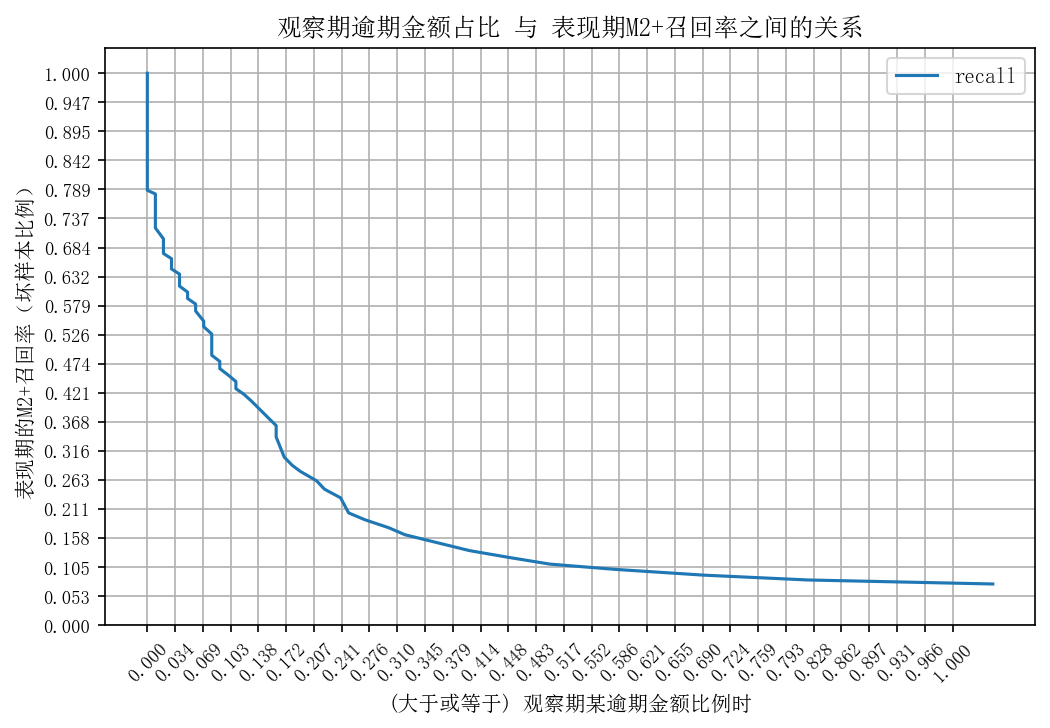

In [8]:
cor_df.plot(kind='line', x='rate_value',y='recall',
            xticks=np.linspace(0,1,30),rot=45,
            yticks=np.linspace(0,1,20),
            xlabel='(大于或等于) 观察期某逾期金额比例时',ylabel='表现期的M2+召回率（坏样本比例）',
            figsize=(8,5), grid=True,
            title = '观察期逾期金额占比 与 表现期M2+召回率之间的关系',
            fontsize=9)


###### 逾期占比二分类化 (25%为阈值)

In [9]:
df_label['target_oweRate_binary'] = np.where(df_label['target_owe_fee_rate'] >= 0.25, 1, 0)

In [35]:
print(df_label['target_oweRate_binary'].value_counts())
print(df_label['target_oweRate_binary'].value_counts(normalize=True))

0    21337
1     4129
Name: target_oweRate_binary, dtype: int64
0    0.837862
1    0.162138
Name: target_oweRate_binary, dtype: float64


##### 数据预处理

    工商表预处理

In [11]:
df_gs = pd.read_csv('data/wide_gongshang.csv')
df_gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31137 entries, 0 to 31136
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       31137 non-null  int64  
 1   entid            31137 non-null  object 
 2   regcap           31137 non-null  float64
 3   regcapcur        29380 non-null  object 
 4   regcapcurcode    29381 non-null  float64
 5   entstatuscode    31137 non-null  int64  
 6   esdate           31137 non-null  object 
 7   opfrom           31137 non-null  object 
 8   opto             31137 non-null  object 
 9   enttypecode      31131 non-null  float64
 10  regorgcode       31136 non-null  float64
 11  ancheyear        30263 non-null  float64
 12  industryconame   31083 non-null  object 
 13  natural_cust_id  31137 non-null  int64  
 14  dis_sb           352 non-null    float64
 15  enement_per      1891 non-null   float64
 16  ope_abty         0 non-null      float64
 17  break_law   

In [12]:
if df_gs['entid'].nunique() == len(df_gs):
    print('>>> 主键唯一性成立！')
else:
    print('>>> 主键存在重复！')

>>> 主键存在重复！


In [13]:
# 粗暴去除主键重复值
df_gs.drop_duplicates(subset=['entid','natural_cust_id'],inplace=True)
if df_gs['entid'].nunique() == len(df_gs):
    print('>>> 主键唯一性成立！')
else:
    print('>>> 主键存在重复！')

>>> 主键唯一性成立！


In [14]:
df_gs['regcap'].describe()

count    2.541200e+04
mean     9.843294e+04
std      1.267759e+06
min      0.000000e+00
25%      1.000000e+02
50%      2.000000e+03
75%      1.910776e+04
max      1.550000e+08
Name: regcap, dtype: float64

In [15]:
# 注册资本汇率转换
ex_rate = {"人民币元":1,"美元":7.08,"香港元":0.90,"欧元":7.59,"日元":0.051,
           "瑞上法郎":7.83,"英镑":8.79,"澳大利亚元":4.62,"德国马克":4.59,"新加坡元":5.24,
           "阿富汗尼":0.081}
for currency, rate in ex_rate.items():
    df_gs['regcap'][df_gs['regcapcur'] == currency] = df_gs['regcap'] * rate
df_gs['regcap'].describe()

C:\Users\Windows\AppData\Local\Temp\ipykernel_23568\765047211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gs['regcap'][df_gs['regcapcur'] == currency] = df_gs['regcap'] * rate
C:\Users\Windows\AppData\Local\Temp\ipykernel_23568\765047211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gs['regcap'][df_gs['regcapcur'] == currency] = df_gs['regcap'] * rate
C:\Users\Windows\AppData\Local\Temp\ipykernel_23568\765047211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

count    2.541200e+04
mean     1.033903e+05
std      1.269978e+06
min      0.000000e+00
25%      1.000000e+02
50%      2.005400e+03
75%      2.293752e+04
max      1.550000e+08
Name: regcap, dtype: float64

In [16]:
# 对注册资本是否人民币、港元和美元进行二分类，其它不管
df_gs['is_rmb'] = np.where(df_gs['regcapcur'] == '人民币元', 1, 0)
df_gs['is_usd'] = np.where(df_gs['regcapcur'] == '美元', 1, 0)
df_gs['is_hkd'] = np.where(df_gs['regcapcur'] == '香港元', 1, 0)

In [17]:
# 只保留有用的特征：natural_cust_id、注册资本、注册资本所用货币、行业、break_law
df_gs = df_gs[['natural_cust_id','regcap','is_rmb','is_usd','is_hkd','industryconame','break_law']]
df_gs.rename(str.upper, axis='columns',inplace=True)
df_gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25412 entries, 0 to 31136
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NATURAL_CUST_ID  25412 non-null  int64  
 1   REGCAP           25412 non-null  float64
 2   IS_RMB           25412 non-null  int32  
 3   IS_USD           25412 non-null  int32  
 4   IS_HKD           25412 non-null  int32  
 5   INDUSTRYCONAME   25369 non-null  object 
 6   BREAK_LAW        22 non-null     float64
dtypes: float64(2), int32(3), int64(1), object(1)
memory usage: 1.3+ MB


    左连接出账表

In [18]:
if df_label['NATURAL_CUST_ID'].nunique() == len(df_label):
    print('>>> 主键唯一性成立！')
else:
    print('>>> 主键存在重复！')

>>> 主键唯一性成立！


In [19]:
df_label = df_label.merge(df_gs, how='left')
df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25466 entries, 0 to 25465
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   NATURAL_CUST_ID                        25466 non-null  int64  
 1   target_M2plus                          25466 non-null  int64  
 2   target_owe_fee_rate                    25466 non-null  float64
 3   FLAG_M2_HISTORY                        25466 non-null  int64  
 4   OWETAG_OWE_FEE_N_RATIO_VL_OLD          25466 non-null  float64
 5   OWETAG_OWE_FEE_L12M_RATIO_VL_OLD       25466 non-null  float64
 6   OWETAG_OWE_TIME_L12M_MX_OLD            25466 non-null  int64  
 7   OWETAG_OWE_PERIOD_L12M_MX              25466 non-null  int64  
 8   COSHQW_ACCT_FEE_N_D3MR                 25466 non-null  float64
 9   COSHQW_CUST_N_D3M                      25466 non-null  int64  
 10  FLAG_M1_HISTORY                        25466 non-null  int64  
 11  CO

    缺失值处理

In [20]:
np.sum(df_label.isna()) / len(df_label)

NATURAL_CUST_ID                          0.000000
target_M2plus                            0.000000
target_owe_fee_rate                      0.000000
FLAG_M2_HISTORY                          0.000000
OWETAG_OWE_FEE_N_RATIO_VL_OLD            0.000000
OWETAG_OWE_FEE_L12M_RATIO_VL_OLD         0.000000
OWETAG_OWE_TIME_L12M_MX_OLD              0.000000
OWETAG_OWE_PERIOD_L12M_MX                0.000000
COSHQW_ACCT_FEE_N_D3MR                   0.000000
COSHQW_CUST_N_D3M                        0.000000
FLAG_M1_HISTORY                          0.000000
COSHQW_VHRSK_PROD_FEE_L6M_RATIO_VL       0.000000
COSHQW_HRSK_PROD_FEE_L6M_RATIO_VL_OLD    0.000000
BASIC_AGE                                0.000000
FLAG_PREPAY                              0.000000
BASIC_CAPITAL                            0.000000
MNG_INFO_MANAGER_N                       0.000000
target_oweRate_binary                    0.000000
REGCAP                                   0.002120
IS_RMB                                   0.002120


In [21]:
df_label.drop(columns=['BREAK_LAW'], inplace=True)

In [22]:
fill_zero = ['IS_RMB','IS_USD','IS_HKD']
fill_unknown = ['INDUSTRYCONAME']
fill_median = ['REGCAP']

df_label[fill_zero] = df_label[fill_zero].fillna(0)
df_label[fill_unknown] = df_label[fill_unknown].fillna('unknown')
df_label[fill_median] = df_label[fill_median].fillna(df_label[fill_median].median())

np.sum(df_label.isna()) / len(df_label)

NATURAL_CUST_ID                          0.0
target_M2plus                            0.0
target_owe_fee_rate                      0.0
FLAG_M2_HISTORY                          0.0
OWETAG_OWE_FEE_N_RATIO_VL_OLD            0.0
OWETAG_OWE_FEE_L12M_RATIO_VL_OLD         0.0
OWETAG_OWE_TIME_L12M_MX_OLD              0.0
OWETAG_OWE_PERIOD_L12M_MX                0.0
COSHQW_ACCT_FEE_N_D3MR                   0.0
COSHQW_CUST_N_D3M                        0.0
FLAG_M1_HISTORY                          0.0
COSHQW_VHRSK_PROD_FEE_L6M_RATIO_VL       0.0
COSHQW_HRSK_PROD_FEE_L6M_RATIO_VL_OLD    0.0
BASIC_AGE                                0.0
FLAG_PREPAY                              0.0
BASIC_CAPITAL                            0.0
MNG_INFO_MANAGER_N                       0.0
target_oweRate_binary                    0.0
REGCAP                                   0.0
IS_RMB                                   0.0
IS_USD                                   0.0
IS_HKD                                   0.0
INDUSTRYCO

In [23]:
if df_label['NATURAL_CUST_ID'].nunique() == len(df_label):
    print('>>> 主键唯一性成立！')
else:
    print('>>> 主键存在重复！')

>>> 主键唯一性成立！


In [24]:
len(df_label)

25466

    类别变量概率化

In [25]:
def bin_category(df, multicat_col, target_col):
    from tqdm import tqdm
    value_mapper = {cat_value:(len(df[(df[multicat_col] == cat_value) & (df[target_col] == 1)]),
                               len(df[(df[multicat_col] == cat_value) & (df[target_col] == 0)]))
                               for cat_value in df[multicat_col].unique()}
    if target_col == 'FLAG_M2_HISTORY':
        new_col = multicat_col + '_M2+Prob'
    else:
        new_col = multicat_col + '_oweRateProb'
    df[multicat_col+'_prob'] = 0 # 初始化
    for cat_value, probs in tqdm(value_mapper.items()):
        df.loc[df[multicat_col] == cat_value, new_col] = np.log1p(probs[0] / (probs[1]+1))

In [26]:
# 行业种类对M2+的贡献概率
multi_category_cols = 'INDUSTRYCONAME'
target_col = 'FLAG_M2_HISTORY' # 选择观察期的M2+作为目标，以免数据泄露
bin_category(df_label, multi_category_cols, target_col)

100%|██████████| 1165/1165 [00:03<00:00, 304.78it/s]


In [27]:
# 行业种类对Rate二分类的贡献概率
multi_category_cols = 'INDUSTRYCONAME'
target_col = 'target_oweRate_binary' # 已经是观察期，无所谓
bin_category(df_label, multi_category_cols, target_col)

100%|██████████| 1165/1165 [00:04<00:00, 275.33it/s]


In [28]:
df_label.columns

Index(['NATURAL_CUST_ID', 'target_M2plus', 'target_owe_fee_rate',
       'FLAG_M2_HISTORY', 'OWETAG_OWE_FEE_N_RATIO_VL_OLD',
       'OWETAG_OWE_FEE_L12M_RATIO_VL_OLD', 'OWETAG_OWE_TIME_L12M_MX_OLD',
       'OWETAG_OWE_PERIOD_L12M_MX', 'COSHQW_ACCT_FEE_N_D3MR',
       'COSHQW_CUST_N_D3M', 'FLAG_M1_HISTORY',
       'COSHQW_VHRSK_PROD_FEE_L6M_RATIO_VL',
       'COSHQW_HRSK_PROD_FEE_L6M_RATIO_VL_OLD', 'BASIC_AGE', 'FLAG_PREPAY',
       'BASIC_CAPITAL', 'MNG_INFO_MANAGER_N', 'target_oweRate_binary',
       'REGCAP', 'IS_RMB', 'IS_USD', 'IS_HKD', 'INDUSTRYCONAME',
       'INDUSTRYCONAME_prob', 'INDUSTRYCONAME_M2+Prob',
       'INDUSTRYCONAME_oweRateProb'],
      dtype='object')

array([[<Axes: title={'center': 'INDUSTRYCONAME_M2+Prob'}>,
        <Axes: title={'center': 'INDUSTRYCONAME_oweRateProb'}>]],
      dtype=object)

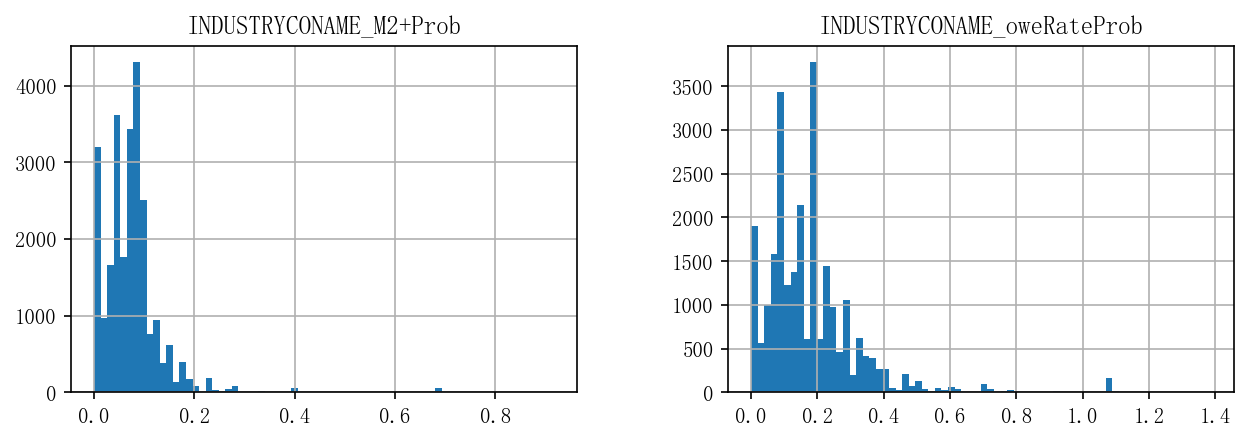

In [29]:
df_label[['INDUSTRYCONAME_M2+Prob','INDUSTRYCONAME_oweRateProb']].hist(figsize=(10,3),bins=70)

In [30]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25466 entries, 0 to 25465
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   NATURAL_CUST_ID                        25466 non-null  int64  
 1   target_M2plus                          25466 non-null  int64  
 2   target_owe_fee_rate                    25466 non-null  float64
 3   FLAG_M2_HISTORY                        25466 non-null  int64  
 4   OWETAG_OWE_FEE_N_RATIO_VL_OLD          25466 non-null  float64
 5   OWETAG_OWE_FEE_L12M_RATIO_VL_OLD       25466 non-null  float64
 6   OWETAG_OWE_TIME_L12M_MX_OLD            25466 non-null  int64  
 7   OWETAG_OWE_PERIOD_L12M_MX              25466 non-null  int64  
 8   COSHQW_ACCT_FEE_N_D3MR                 25466 non-null  float64
 9   COSHQW_CUST_N_D3M                      25466 non-null  int64  
 10  FLAG_M1_HISTORY                        25466 non-null  int64  
 11  CO

In [33]:
df_label.drop(columns=['INDUSTRYCONAME_prob'], inplace=True)

In [34]:
df_label.to_csv('data/widetable_cleaned.csv', index=False)